## <font color='red'>EULER HERMES ASSIGNMENT PROJECT</font>

**Alfredo Cinelli**

The goal of this project is to build a binary classification model able to classify whether a basketball player is selected to be in the **Hall of Fame** or not.
The dataset is thus composed:
- **playerID**: Player Identification.
- **stint**: Player’s stint. (Yearly avg.)
- **minutes**: Player’s in game minutes. (Yearly avg.)
- **rebounds**: Player’s in game rebounds. (Yearly avg.)
- **assists**: Player’s in game assists. (Yearly avg.)
- **steals**: Player’s in game steals. (Yearly avg.)
- **blocks**: Player’s in game blocks. (Yearly avg.)
- **turnovers**: Player’s in game turnovers. (Yearly avg.)
- **careerDuration**: Player’s career duration. (in years)
- **pos**: Player’s in game position.
- **height**: Player’s height. (inches)
- **weight**: Player’s weight. (lbs)
- **college**: Player’s college name.
- **birthDate**: Player’s birthdate.
- **birthState**: Players’s birth state.
- **birthCountry**: Player’s birth country
- **ethnicity**: Player’s ethnicity
- **target**: If player is scored average 1000+ points (yearly avg.) in his/her career to deserve to be in Hall of Fame

The project is then divided into **four main parts**:
1. Import and set packages
2. Import data and run Exploratory Data Analysis
3. Model building and tuning
4. Model evaluation and judgment

### Import and set packages

In [3]:
# Import the main packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, brier_score_loss, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import scikitplot as skplt
from imblearn.ensemble import RUSBoostClassifier
from scipy import stats
import optuna
import shap
#import joblib as jb
#from deepchecks import Dataset
#from deepchecks.suites import full_suite
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
from IPython.display import Image
import os
os.chdir('c:\\Users\\alfredo.cinelli\\Desktop\\IMB_Classification')

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15, 7)})


### Exploratory Data Analysis

In [9]:
# Load the data and print it

data = pd.read_csv('data/basketball_hall_of_fame_df.csv', sep=';')
data.head() # Get the first 5 rows

,playerID,stint,minutes,rebounds,assists,steals,blocks,turnovers,careerDuration,pos,height,weight,college,birthDate,birthState,birthCountry,ethnicity,target
0,abdelal01,1.29,457.14,120.86,12.14,10.14,10.00,35.29,7,F-C,82.0,240.0,Duke,1968-06-24,NaN,EGY,B,0.0
1,abdulka01,1.00,2872.30,872.00,283.00,58.00,159.45,126.35,20,C,85.0,225.0,UCLA,1947-04-16,NY,USA,B,1.0
2,abdulma01,1.09,1745.64,195.09,323.18,2.36,0.55,0.00,11,G,74.0,185.0,UCLA,1942-04-15,DE,USA,B,0.0
3,abdulma02,1.00,1736.44,120.78,231.00,54.11,5.11,107.00,9,G,73.0,162.0,Louisiana State,1969-03-09,MS,USA,B,0.0
4,abdulta01,1.14,683.29,110.00,37.71,26.00,11.71,43.71,8,G-F,78.0,223.0,San Jose State,1974-11-03,NaN,FRA,B,0.0


In [10]:
# Get a general idea of the datase at hand

data.info()

# It can be seen that only the features pos, birthState and birthCountry have null values. However the former two may 
# be not used in the model building because they are not (in my opinion) relevant. Morevoer pos has just 3 null values
# thus given that the instances are 2366 I chose to just drop the 3 nulls instead of imputing them (dropping 0.1% is doable).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2366 entries, 0 to 2365
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   playerID        2366 non-null   object 
 1   stint           2366 non-null   float64
 2   minutes         2366 non-null   float64
 3   rebounds        2366 non-null   float64
 4   assists         2366 non-null   float64
 5   steals          2366 non-null   float64
 6   blocks          2366 non-null   float64
 7   turnovers       2366 non-null   float64
 8   careerDuration  2366 non-null   int64  
 9   pos             2363 non-null   object 
 10  height          2366 non-null   float64
 11  weight          2366 non-null   float64
 12  college         2366 non-null   object 
 13  birthDate       2366 non-null   object 
 14  birthState      2132 non-null   object 
 15  birthCountry    2303 non-null   object 
 16  ethnicity       2366 non-null   object 
 17  target          2366 non-null   f

In [94]:
# Check for duplicates

len_before = data.shape[0] # Number of instances before checking for duplicates
data.drop_duplicates(inplace=True) # Drop any duplicates in the rows
len_after = data.shape[0] # Number of instances after checking for duplicates

print(f'Observations before checking for duplicates: {len_before}')
print(f'Observations after checking for duplicates: {len_after}')
print(f'Observations dropped: {len_before - len_after}')

# It can be seen that, fortunately, there are no duplicates in the dataset.

Observations before checking for duplicates: 2366
Observations after checking for duplicates: 2366
Observations dropped: 0


In [95]:
# Create new features

#data['bmi'] = (data['weight']/data['height']**2)*703 # Body Mass Index (BMI)

#data['birthYear'] = [str(data.birthDate[i].split('-')[0]) for i in range(data.shape[0])] # Year of birth of each player
#data.drop(columns=['height', 'weight'], inplace=True)

# None of the above new features added performance to the final model



In [96]:
# Get the categorical and numerical columns names

cat_col = [col for col in data.columns if data[col].dtype == 'object'] # Categorical columns
num_col = [col for col in data.columns if data[col].dtype != 'object'] # Numerical columns

print('Categorical Columns: ', cat_col)
print('Numerical Columns: ', num_col)
print(f'Total columns: {len(cat_col) + len(num_col)}') # As it can be seen no column has been left behind

Categorical Columns:  ['playerID', 'pos', 'college', 'birthDate', 'birthState', 'birthCountry', 'ethnicity']
Numerical Columns:  ['stint', 'minutes', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'careerDuration', 'height', 'weight', 'target']
Total columns: 18


In [97]:
# Quick statistics of numerical columns

data[num_col].describe().round(2)

# It can be seen that the scale of the features is different to each other, for instance the scale is very distant between
# stint and minutes, or careerDuration and rebounds. Therefore, in my opinion, a Scaler is needed before feeding the data
# to a model (e.g. MinMaxScaler, StandardScaler, etc).

,stint,minutes,rebounds,assists,steals,blocks,turnovers,careerDuration,height,weight,target
count,2366.00,2366.00,2366.00,2366.00,2366.00,2366.00,2366.00,2366.00,2366.00,2366.00,2366.0
mean,1.11,1143.15,213.54,105.68,28.75,17.16,55.10,8.26,78.31,209.32,0.1
std,0.19,684.30,177.88,103.73,29.33,26.25,51.46,4.24,3.55,25.22,0.3
min,0.00,6.75,0.00,0.00,0.00,0.00,0.00,3.00,63.00,130.00,0.0
25%,1.00,580.40,85.42,33.00,4.80,1.37,11.00,4.25,76.00,190.00,0.0
50%,1.07,1089.22,171.00,73.40,21.22,7.60,43.73,8.00,79.00,210.00,0.0
75%,1.19,1649.68,291.42,143.66,44.30,20.92,85.37,11.00,81.00,225.00,0.0
max,3.00,3190.60,1663.08,831.89,193.00,278.55,283.23,24.00,91.00,303.00,1.0


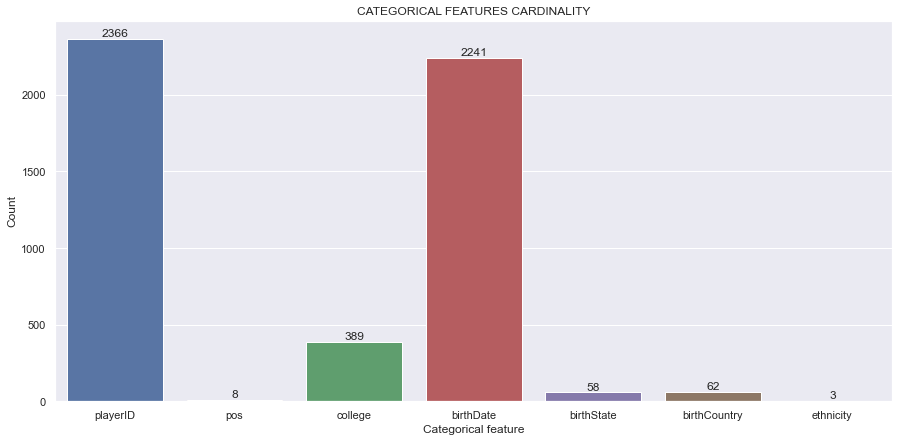

In [98]:
# Look at the cardinality of categorical features

card = [len(data[col].unique()) for col in cat_col]

fig, ax = plt.subplots()
fig = sns.barplot(x=cat_col, y=card)
fig.bar_label(fig.containers[0])
ax.set_xlabel('Categorical feature')
ax.set_ylabel('Count')
ax.set_title('CATEGORICAL FEATURES CARDINALITY')
pass

# It can be seen that the cardinality for some features such as playerID (which is not useful at all) or birthDate is
# very large, thus this can be cause problems in model training when using OneHotEncoding. Fortunately some of the
# features with high cardinality are, in my opinion, useless for the model bulding. Indeed, as done below the feature
# with the highest cardinality that has been used is 'college'.

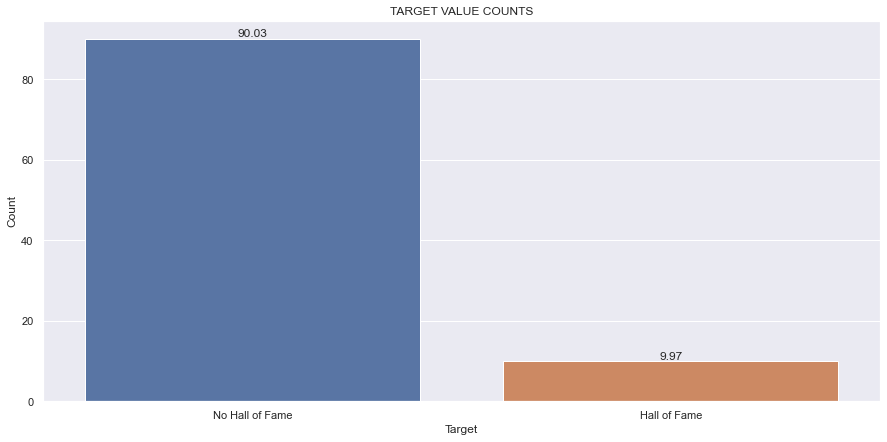

In [99]:
# Distribuiton of the target variable

fig, ax = plt.subplots()
fig = sns.barplot(x=['No Hall of Fame', 'Hall of Fame'], y=100*data['target'].value_counts(normalize=True).round(4))
fig.bar_label(fig.containers[0])
ax.set_xlabel('Target')
ax.set_ylabel('Count')
ax.set_title('TARGET VALUE COUNTS')
pass

# It can be seen that the No Hall of Fame class (0) accounts for 90% of the dataset, whilst the positive class accounts
# for just 10% of the dataset. Thus, in this case there is an inbalance issue in the target varaible that can be addressed
# in some ways, the one done below is by using a model with resampling embedded.

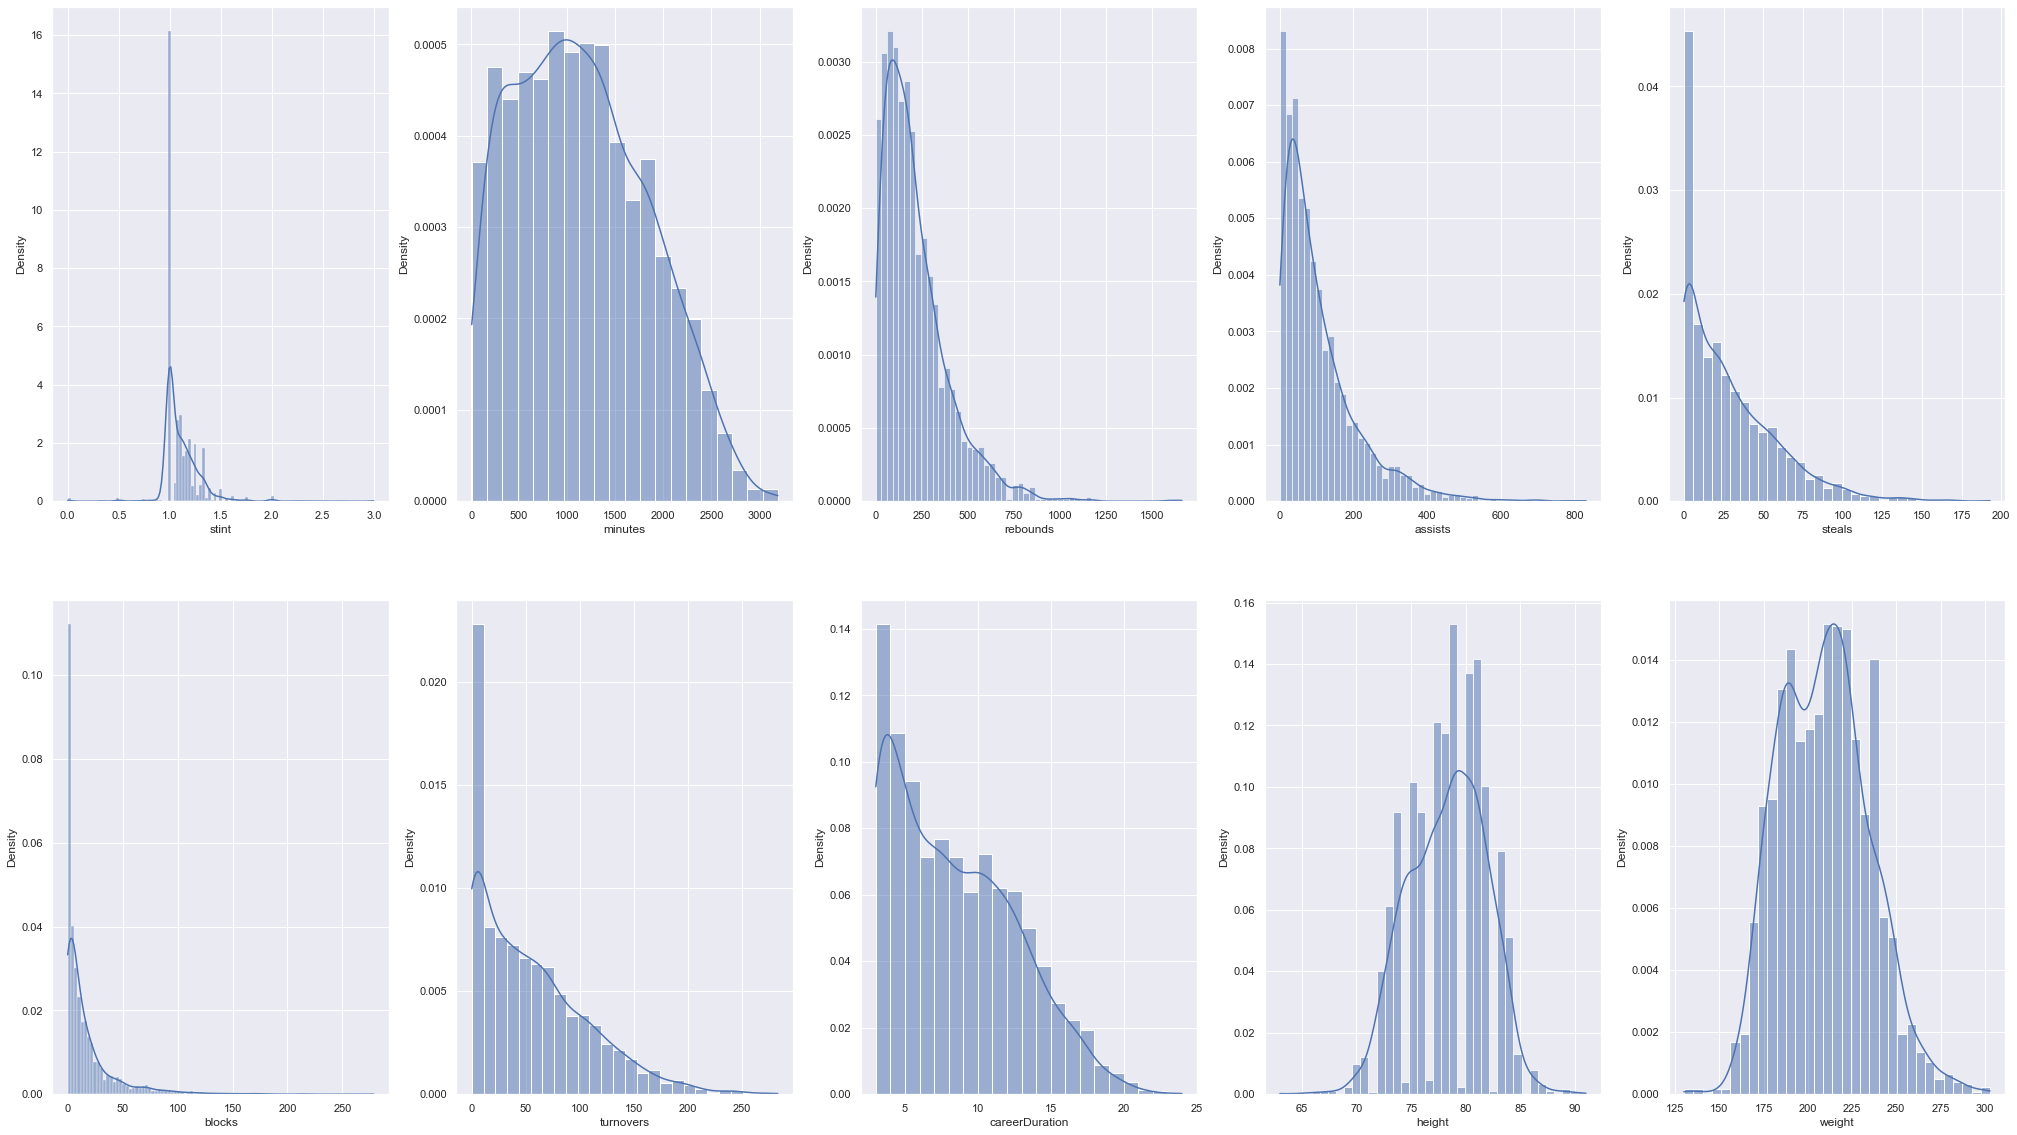

In [100]:
# Distribution of the numerical features

fig, ax = plt.subplots(2,5, figsize=(35,20))
sns.histplot(data=data, x='stint', stat='density', kde=True, ax=ax[0, 0])
sns.histplot(data=data, x='minutes', stat='density', kde=True, ax=ax[0, 1])
sns.histplot(data=data, x='rebounds', stat='density', kde=True, ax=ax[0, 2])
sns.histplot(data=data, x='assists', stat='density', kde=True, ax=ax[0, 3])
sns.histplot(data=data, x='steals', stat='density', kde=True, ax=ax[0, 4])
sns.histplot(data=data, x='blocks', stat='density', kde=True, ax=ax[1, 0])
sns.histplot(data=data, x='turnovers', stat='density', kde=True, ax=ax[1, 1])
sns.histplot(data=data, x='careerDuration', stat='density', kde=True, ax=ax[1, 2])
sns.histplot(data=data, x='height', stat='density', kde=True, ax=ax[1, 3])
sns.histplot(data=data, x='weight', stat='density', kde=True, ax=ax[1, 4])
pass

# It can be seen that the distributions of the numerical features seem to be fair.

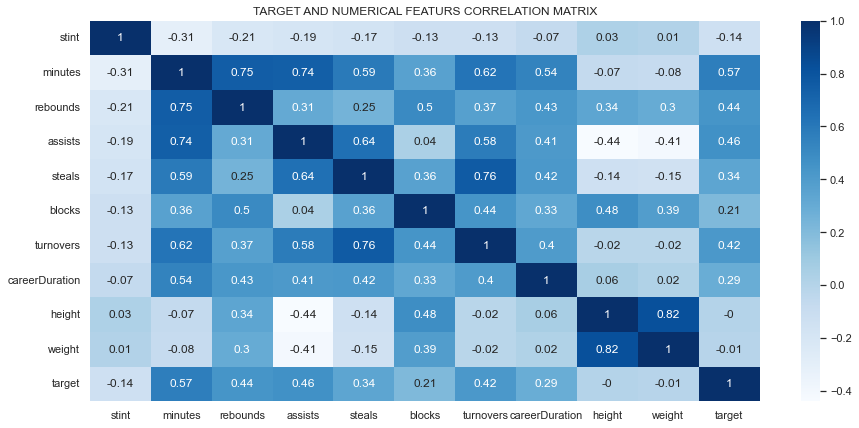

In [101]:
# Correlation between numerical features and target variable

sns.heatmap(data=data[num_col].corr(method='pearson').round(2), annot=True, cmap='Blues')
plt.title('TARGET AND NUMERICAL FEATURS CORRELATION MATRIX')
pass

# It can be seen that the features 'stint', 'minutes', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers' and
# 'carrerDuration' have a good level of correlation with the target variable, whilst both 'height' and 'weight' have
# no relevant correlation with the labels. However, the feature strongly correlated with the target are at the same
# time relevantly correlated to each other, this could cause a problem of multicollinearity when building the model.
# Thus, further investigation on potential multicollinearity has to be made via VIF.

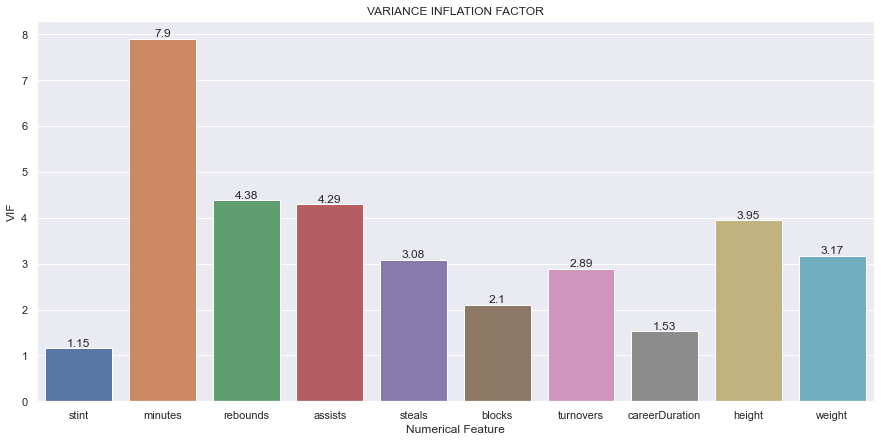

In [102]:
# Multicollinearity analysis via Variance Infaltion Factor (VIF)

X_vif = data[num_col].copy().assign(const=1)
X_vif.drop(columns='target', inplace=True)
vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])], index=X_vif.columns, name='VIF').round(2)
vif.drop(['const'], inplace=True)

fig, ax = plt.subplots()
fig = sns.barplot(x=vif.index, y=vif.values)
fig.bar_label(fig.containers[0])
ax.set_xlabel('Numerical Feature')
ax.set_ylabel('VIF')
ax.set_title('VARIANCE INFLATION FACTOR')
pass

# It can be seen that the VIF is never above 10 which is considered a "dangerous" value in terms of multicollinearity
# of the feature. Therefore, in my opinion, all the numerical features can be kept (even though some of them have no
# correlation with the label, see above).


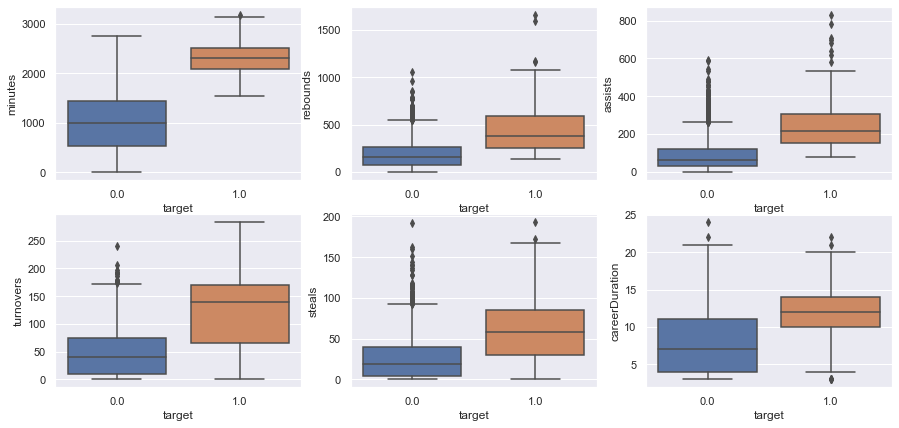

In [103]:
# Distribution of the four most important numerical features grouped by target

fig, ax = plt.subplots(2,3)
sns.boxplot(data=data, x='target', y='minutes', showfliers=True, ax=ax[0,0])
sns.boxplot(data=data, x='target', y='rebounds', showfliers=True, ax=ax[0,1])
sns.boxplot(data=data, x='target', y='assists', showfliers=True, ax=ax[0,2])
sns.boxplot(data=data, x='target', y='turnovers', showfliers=True, ax=ax[1,0])
sns.boxplot(data=data, x='target', y='steals', showfliers=True, ax=ax[1,1])
sns.boxplot(data=data, x='target', y='careerDuration', showfliers=True, ax=ax[1,2])
pass

# It can be seen that the median values for the features 'minutes', 'rebounds', 'assists' and 'turnovers' are always
# greater for the positive class (i.e. Hall of Fame) as expected, because a good player who deserves to be in the 
# Hall of Fame is almost surely a player who playes a lot of minutes, with a lot of assists, rebounds and turnovers.


In [104]:
# Outliers removing from the main features

out_list = ['rebounds', 'assists', 'turnovers', 'steals', 'careerDuration'] # Relevant features

df = data.copy()
df = df[((np.abs(stats.zscore(df[out_list])) < 3).all(axis=1))] # Remove the outliers via teh Z-score
df = df[df.target == 0]
data_1 = data[data.target == 1]

df_out = pd.concat([df, data_1]) # Keep the positive class

# The aim of this snippet is to get rid of outliers by using the standard Z-score procedures. However, I chose not to drop
# the outliers in the positive class in order to reduce (even though slightly) che classes imbalance.


### Model building and tuning

In [105]:
# Filter the features to be used and dived based on the type of preprocessing

num_col = [col for col in num_col if col not in ['target']] # Get rid of the target in the numerical features to be used
cat_col = [col for col in cat_col if col in ['pos', 'ethnicity', 'college']] # Get rid of the categorical features not to One Hot encode

# The categoricasl features I chose to get rid of are 'playerID', 'birthDate', 'birthState', 'birthCountry', 'ethnicity'. The 'playerID'
# is clearly useless because if univoquely refferinf to a single player. The features 'birthDate', 'birthState', 'birthCountry' in my opinion
# are not so relevant and especially 'birthDate' has a huge cardinality, last but not least both 'birthState', 'birthCountry' have many missing
# values and in my opinion their imputing does not worth. Moreover, the presence of 'college' slightly increases the AUC score with the baseline
# model (developed below), therefore I chose to keep it.
# The numerical features I chose to keep 'height', 'weight' even if both have no correlation with the target variable.\
# Accounting for them increased precision, recall, F1 and AUC score in the baseline model.

# It worth noting that due to the dataset imbalance the metric considered are: Precision, Recall, F1 score as threshold
# metrics the ROC AUC as ranking metric and the Brier score as probabilistic metric. Thus, the use of accuracy is 
# completed avoided in order to get rid of misleading results (as known for imbalanced dataset)

In [106]:
# Split the dataset for training and testing purposes

X = df_out[num_col + cat_col] # Matrix of features
y = df_out['target'] # Vector of responses

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2) # Get training and testing dataset


In [107]:
# Build up the preprocessing model pipeline

cat_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
('onehot', OneHotEncoder(handle_unknown='ignore'))]) # Encoder for categorical features via One Hot
num_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
('scaler', MinMaxScaler())]) # Scaler for numerical features, keeping their values in [0,1]

col_prep = ColumnTransformer(transformers=[('cat', cat_trans, cat_col), ('num', num_trans, num_col)]) # Columns transformers

In [108]:
# Try the baseline model (i.e. generalist model with no hyperparameters tuning)

mdl_base = Pipeline(steps=[('preprocessor', col_prep),
('classifier', RUSBoostClassifier(random_state=123))]) # Model entire pipeline

mdl_base.fit(X_train, y_train) # Fit the model to the training set
y_pred = mdl_base.predict(X_test) # Predict the target on the test set (for Out Of Sample metrics)
y_train_pr = mdl_base.predict(X_train) # Predict the target on the training set (for In Sample metrics)
proba = mdl_base.predict_proba(X_test) # Predict the target probabilities on the test set

print(f'The model IS Precision score is: {100*precision_score(y_true=y_train, y_pred=y_train_pr) :.2f}% and OOS is {100*precision_score(y_true=y_test, y_pred=y_pred) :.2f}%')
print(f'The model IS Recall score is: {100*recall_score(y_true=y_train, y_pred=y_train_pr) :.2f}% and OOS is {100*recall_score(y_true=y_test, y_pred=y_pred) :.2f}%')
print(f'The model IS F1 score is: {100*f1_score(y_true=y_train, y_pred=y_train_pr) :.2f}% and OOS is {100*f1_score(y_true=y_test, y_pred=y_pred) :.2f}%')
print(f'The model AUC score is: {100*roc_auc_score(y_test, proba[:, 1]) :.2f}%')
print(f'The model Brier score is: {brier_score_loss(y_test, proba[:,1]) :.2f}%')

# The choice of the model is on the RUSBoostClassifier of the package imblearn, the choice of this model is because, as 
# stated above the dataset is imbalanced (90:10). The RUSBoostClassifier is an hybrid sampling/boosting algorithm for 
# learning from skewed training data. It is vary fast and simple, indeed it's characterized by very few parameters. In
# this application is built on decision trees. 
# [https://sci2s.ugr.es/keel/pdf/algorithm/articulo/2010-IEEE%20TSMCpartA-RUSBoost%20A%20Hybrid%20Approach%20to%20Alleviating%20Class%20Imbalance.pdf]

# It can be seen that the base model is doing bad even in the training set, it seems to under-fit as shown from the threshold
# metrics (Precision, Recall, F1 score), moreover also the ranking score considered (ROC_AUC) can be improved. Last but not
# least the model is not so well calibrated as shown by the probabilistic metric taken into consideration (Brier score).
# Therefore, an optimization of the model is needed.

The model IS Precision score is: 61.96% and OOS is 54.55%
The model IS Recall score is: 86.36% and OOS is 78.95%
The model IS F1 score is: 72.15% and OOS is 64.52%
The model AUC score is: 95.55%
The model Brier score is: 0.12%


In [109]:
# Model hyperparameters optimization function (Optuna framework)

def rus_objective(trial, mdl, X, y, metric):

    n_estimators = trial.suggest_int('classifier__n_estimators', 50, 300, step=50)
    sampling_strategy = trial.suggest_categorical('classifier__sampling_strategy', [0.2, 0.25, 0.3])
    learning_rate = trial.suggest_float('classifier__learning_rate', 0.1, 1, step=0.1)
    
    params = {'classifier__n_estimators':n_estimators,'classifier__sampling_strategy':sampling_strategy, 
    'classifier__learning_rate':learning_rate}

    skc = StratifiedKFold(n_splits=15, shuffle=True)

    mdl.set_params(**params)
    score = cross_val_score(mdl, X, y, scoring=metric, cv=skc, n_jobs=-1).mean()
    
    return score

In [113]:
# Model hyperparameters optimization study

mdl_rus = mdl_rf = Pipeline(steps=[('preprocessor', col_prep),
('classifier', RUSBoostClassifier( random_state=0))]) # Model entire pipeline

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=0),
study_name='RUSBoost Optimization') # Create Optuna study
func = lambda trial: rus_objective(trial, mdl_rus, X_train, y_train, 'roc_auc') # Assing the parameters of the Optuna function (via lambda)
study.optimize(func, timeout=240) # Run the Optuna study setting the time threshold
#jb.dump(study, 'optmized_RUS_AUC.pkl')

# It worth noting that the metric used for hyperparameters optimization is the ROC_AUC which is largely considered one of
# the best metrics for classification with imbalance problems. 
# Actually other metrics like the F1 score has been used, but the ROC_AUC gave the best results.

[I 2022-02-15 15:00:20,381] A new study created in memory with name: RUSBoost Optimization
[I 2022-02-15 15:00:28,918] Trial 0 finished with value: 0.9754472254472256 and parameters: {'classifier__n_estimators': 200, 'classifier__sampling_strategy': 0.2, 'classifier__learning_rate': 0.5}. Best is trial 0 with value: 0.9754472254472256.
[I 2022-02-15 15:00:37,994] Trial 1 finished with value: 0.9766857166857167 and parameters: {'classifier__n_estimators': 200, 'classifier__sampling_strategy': 0.3, 'classifier__learning_rate': 0.4}. Best is trial 1 with value: 0.9766857166857167.
[I 2022-02-15 15:00:47,554] Trial 2 finished with value: 0.9805481005481004 and parameters: {'classifier__n_estimators': 250, 'classifier__sampling_strategy': 0.3, 'classifier__learning_rate': 0.1}. Best is trial 2 with value: 0.9805481005481004.
[I 2022-02-15 15:00:49,877] Trial 3 finished with value: 0.9747662247662247 and parameters: {'classifier__n_estimators': 50, 'classifier__sampling_strategy': 0.25, 'cla

In [118]:
# Set and fit the optimized RUSBoostClassifier

#study = jb.load('optmized_RUS_AUC.pkl')
params = study.best_params
mdl_rus.set_params(**params)
mdl_rus.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pos', 'college',
                                                   'ethnicity']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),

In [119]:
# Get the metrics of the model

y_pred = mdl_rus.predict(X_test)
y_train_pr = mdl_rus.predict(X_train)
proba = mdl_rus.predict_proba(X_test)

print(f'The model IS Precision score is: {100*precision_score(y_true=y_train, y_pred=y_train_pr) :.2f}% and OOS is {100*precision_score(y_true=y_test, y_pred=y_pred) :.2f}%')
print(f'The model IS Recall score is: {100*recall_score(y_true=y_train, y_pred=y_train_pr) :.2f}% and OOS is {100*recall_score(y_true=y_test, y_pred=y_pred) :.2f}%')
print(f'The model IS F1 score is: {100*f1_score(y_true=y_train, y_pred=y_train_pr) :.2f}% and OOS is {100*f1_score(y_true=y_test, y_pred=y_pred) :.2f}%')
print(f'The model AUC score is: {100*roc_auc_score(y_test, proba[:, 1]) :.2f}%')
print(f'The model Brier score is: {brier_score_loss(y_test, proba[:,1]) :.2f}%')

# It can be seen that the model is sharply improved in the test set threshold metrics. Morever, the model is no longer
# overfitting in the training set, indeed the deterioration of the threshold metrics is lower than 10% which is considered
# a flag for overfitting (rule of thumb). Furthermore, also the ROC_AUC got better and last but not leas the model is finally
# well calibrated with a Brier score very close to 0.

The model IS Precision score is: 77.06% and OOS is 70.21%
The model IS Recall score is: 89.90% and OOS is 86.84%
The model IS F1 score is: 82.98% and OOS is 77.65%
The model AUC score is: 97.34%
The model Brier score is: 0.05%


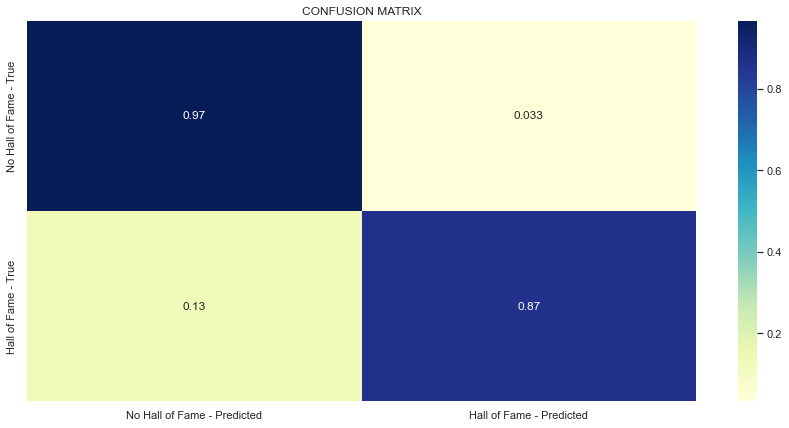

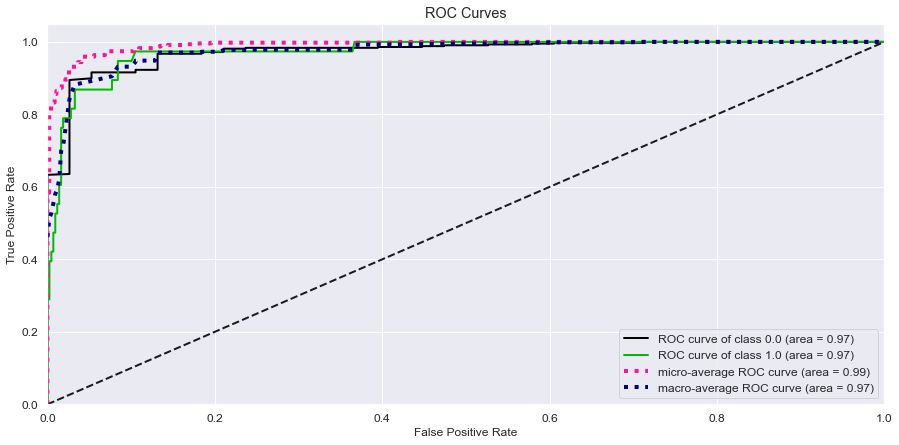

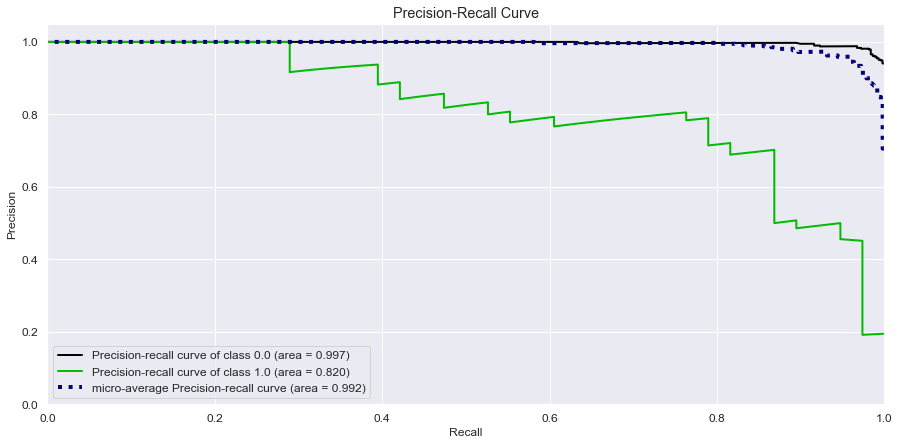

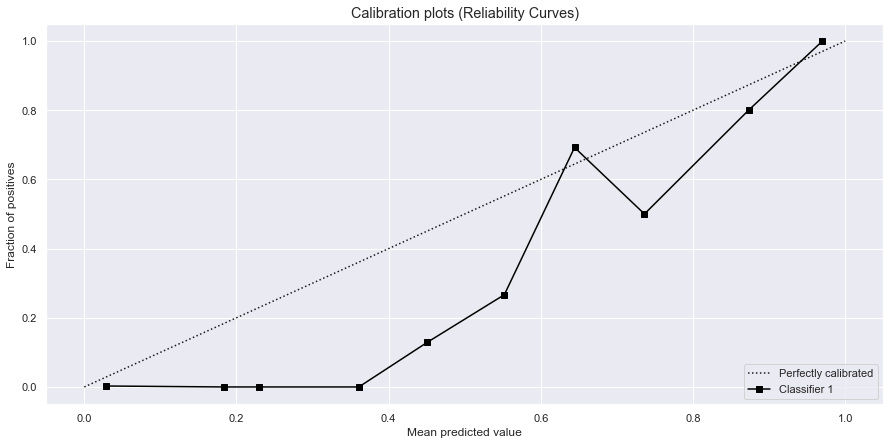

In [590]:
# Inspect some useful validation plots

s = confusion_matrix(y_true=y_test, y_pred=y_pred) # Compute the confusion matrix
s_norm = s/s.sum(axis=1, keepdims=True) # Normalize the confusion matrix in order to see relative numbers

fig, ax = plt.subplots()
fig = sns.heatmap(s_norm, annot=True, yticklabels=['No Hall of Fame - True', 'Hall of Fame - True'],
xticklabels=['No Hall of Fame - Predicted', 'Hall of Fame - Predicted'], cmap="YlGnBu")
ax.set_title('CONFUSION MATRIX')

skplt.metrics.plot_roc(y_test, proba) # Plot the ROC curve with values
skplt.metrics.plot_precision_recall(y_test, proba) # Plot the PR curve with values
skplt.metrics.plot_calibration_curve(y_test, [proba]) # Plot the calibration curve
pass

# It can be seen from the confusion matrix that, as expected, the model is doing very good in predicting the class 0 
# (i.e. No Hall of Fame) with a small number of false positive, however the model is doing worse on predicting the 
# positive class (i.e. Hall of Fame) and indeed the false negative percentage is higher. This behaviour is expected
# whenever the positive class is under-represented as in this case. But, at the end the overall result is quite good
# in my opinion. Morevoer, the ROC curves are showing that the model is dong very good and the same is shown by the
# PRC curve with a lower performance for the positive class. Last, the calibration curve shows that the model is well
# calibrated.

In [4]:
# Show the main threshold metrics for both classes in both train and test 

Image(url='plot/deepchecks_plot.png')

# The plot below (obtained via deepchecks a very useful library relased as open source recentely) shows as stated above
# how the model is keeping its performance on the threshold metrics almost the same between train and test data. Thus,
# confirming that the model is not over/under fitting at all (which is a very good news)

# Link to deepcheks: https://deepchecks.com/

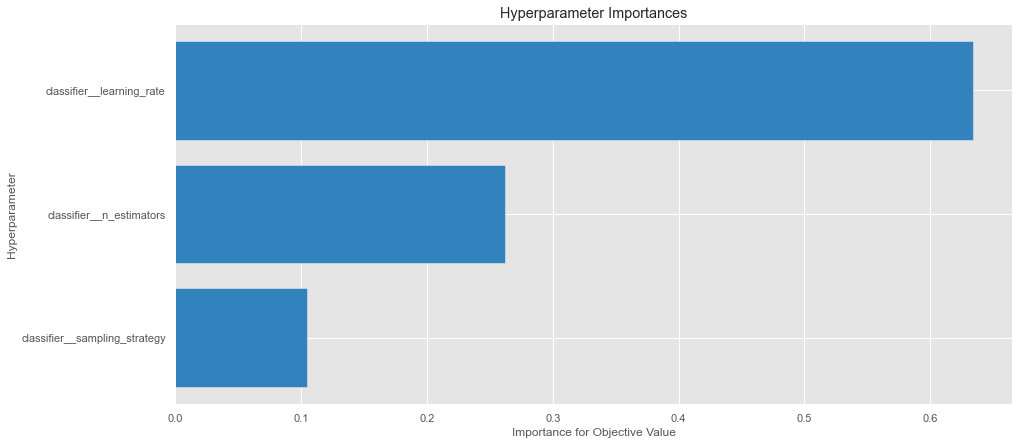

In [565]:
# Take a look at the importance of the hyperparameters 

optuna.visualization.matplotlib.plot_param_importances(study)
pass

# A very useful method of Optuna is the possibility to look at the hyperparameters importances during optimization
# It can be seen that the learning rate is by far the most important followed by the number of estimators.
# The learning rate is a crucial hyperparameter when optimizing a model in order to find a trade off.

In [569]:
# Shap framework building

col_name = list(mdl_rus['preprocessor'].transformers_[0][1][1].fit(X_train[cat_col]).get_feature_names()) + num_col # Get the columns names

X_test_p = pd.DataFrame(mdl_rus['preprocessor'].transform(X_test).toarray(), columns=col_name) # Preprocess directly the test set assigning the names
explainer = shap.Explainer(mdl_rus['classifier'].predict, X_test_p) # Set the SHAP object in order to get values
#shap_values = explainer(X_test_p) # Get the Shapley values (need some time)

#jb.dump(shap_values, 'shap_values.pkl')

Permutation explainer: 467it [07:52,  1.03s/it]                         


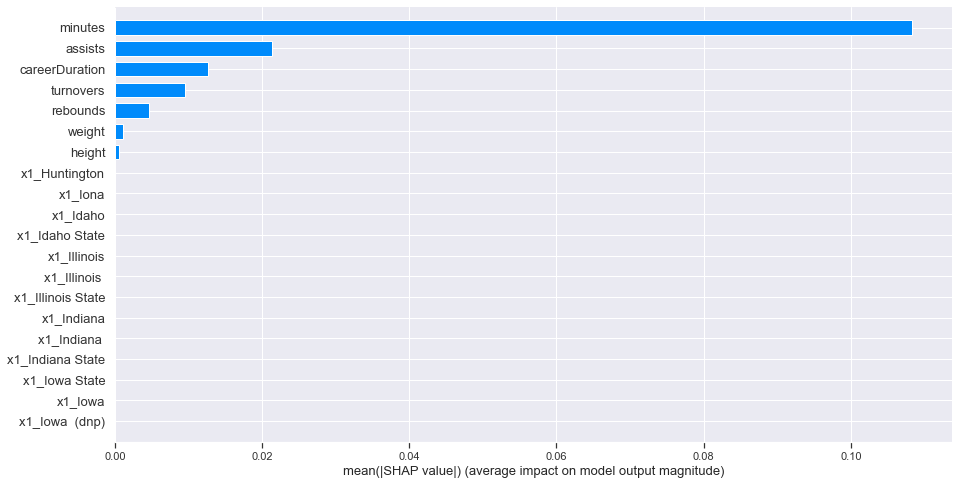

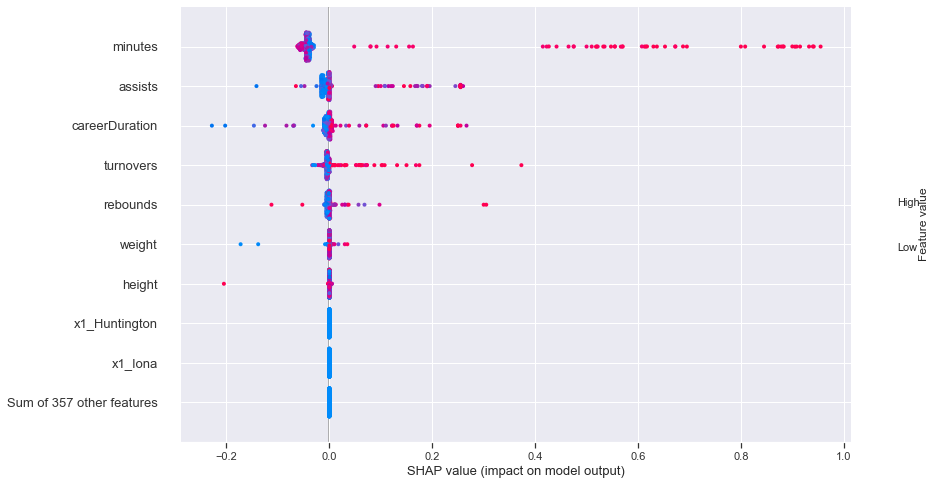

In [595]:
# Shap plots for Global interpretability

#shap_values = jb.load('shap_values.pkl')

shap.summary_plot(shap_values, plot_size=(15,8), plot_type='bar') # Feature importance with magnitude only - Global interpretability
shap.plots.beeswarm(shap_values, plot_size=(15,8)) # Feature importance with the sign and magnitude - Global interpretability

# It can be seen that the most important feature on the model output is by far the minutes played by the player, followed
# by the amount of assists, the careed duration, the turnovers and rebounds. The other features are almost with no impact.
# The importance of the aforementioned parameters is intuitive, because these are objective parameters indicating the quality
# of the player. Indeed, as shown by the beeswarm plot, the impact of minutes, assists, career duration, turnover and
# rebounds is positive. Thus, the higher are these features the larger is the possibility of the player to be eligible for
# being in the Hall of Fame. The opposite is also true, so whenever these features are low the ouput is going towards the
# negative class (even though the relation is on this side not so strong as the "positive" side).